In [13]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rcParams['font.family']=['Palatino']
plt.rc('text', usetex=True)


import clmm.dataops as da
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import chi2
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import binned_statistic
import corner
import math

In [14]:
cluster_m = 1.e15
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
concentration = 4

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination

def create_mock_cluster(shapenoise, redshift, nbins, method=None):

    random.seed(0)

    if type(redshift) == float or type(redshift) == str:
        data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, redshift, zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
    else:
        data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, redshift[0], zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=redshift[1], ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

    gc   = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

    if method:
        bin_edges = da.make_bins(0.7, 4, nbins, method=method)
    else:
        bin_edges = da.make_bins(0.7, 4, nbins)

    gc.compute_tangential_and_cross_components(geometry="flat")
    gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
    
    return gc

/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt


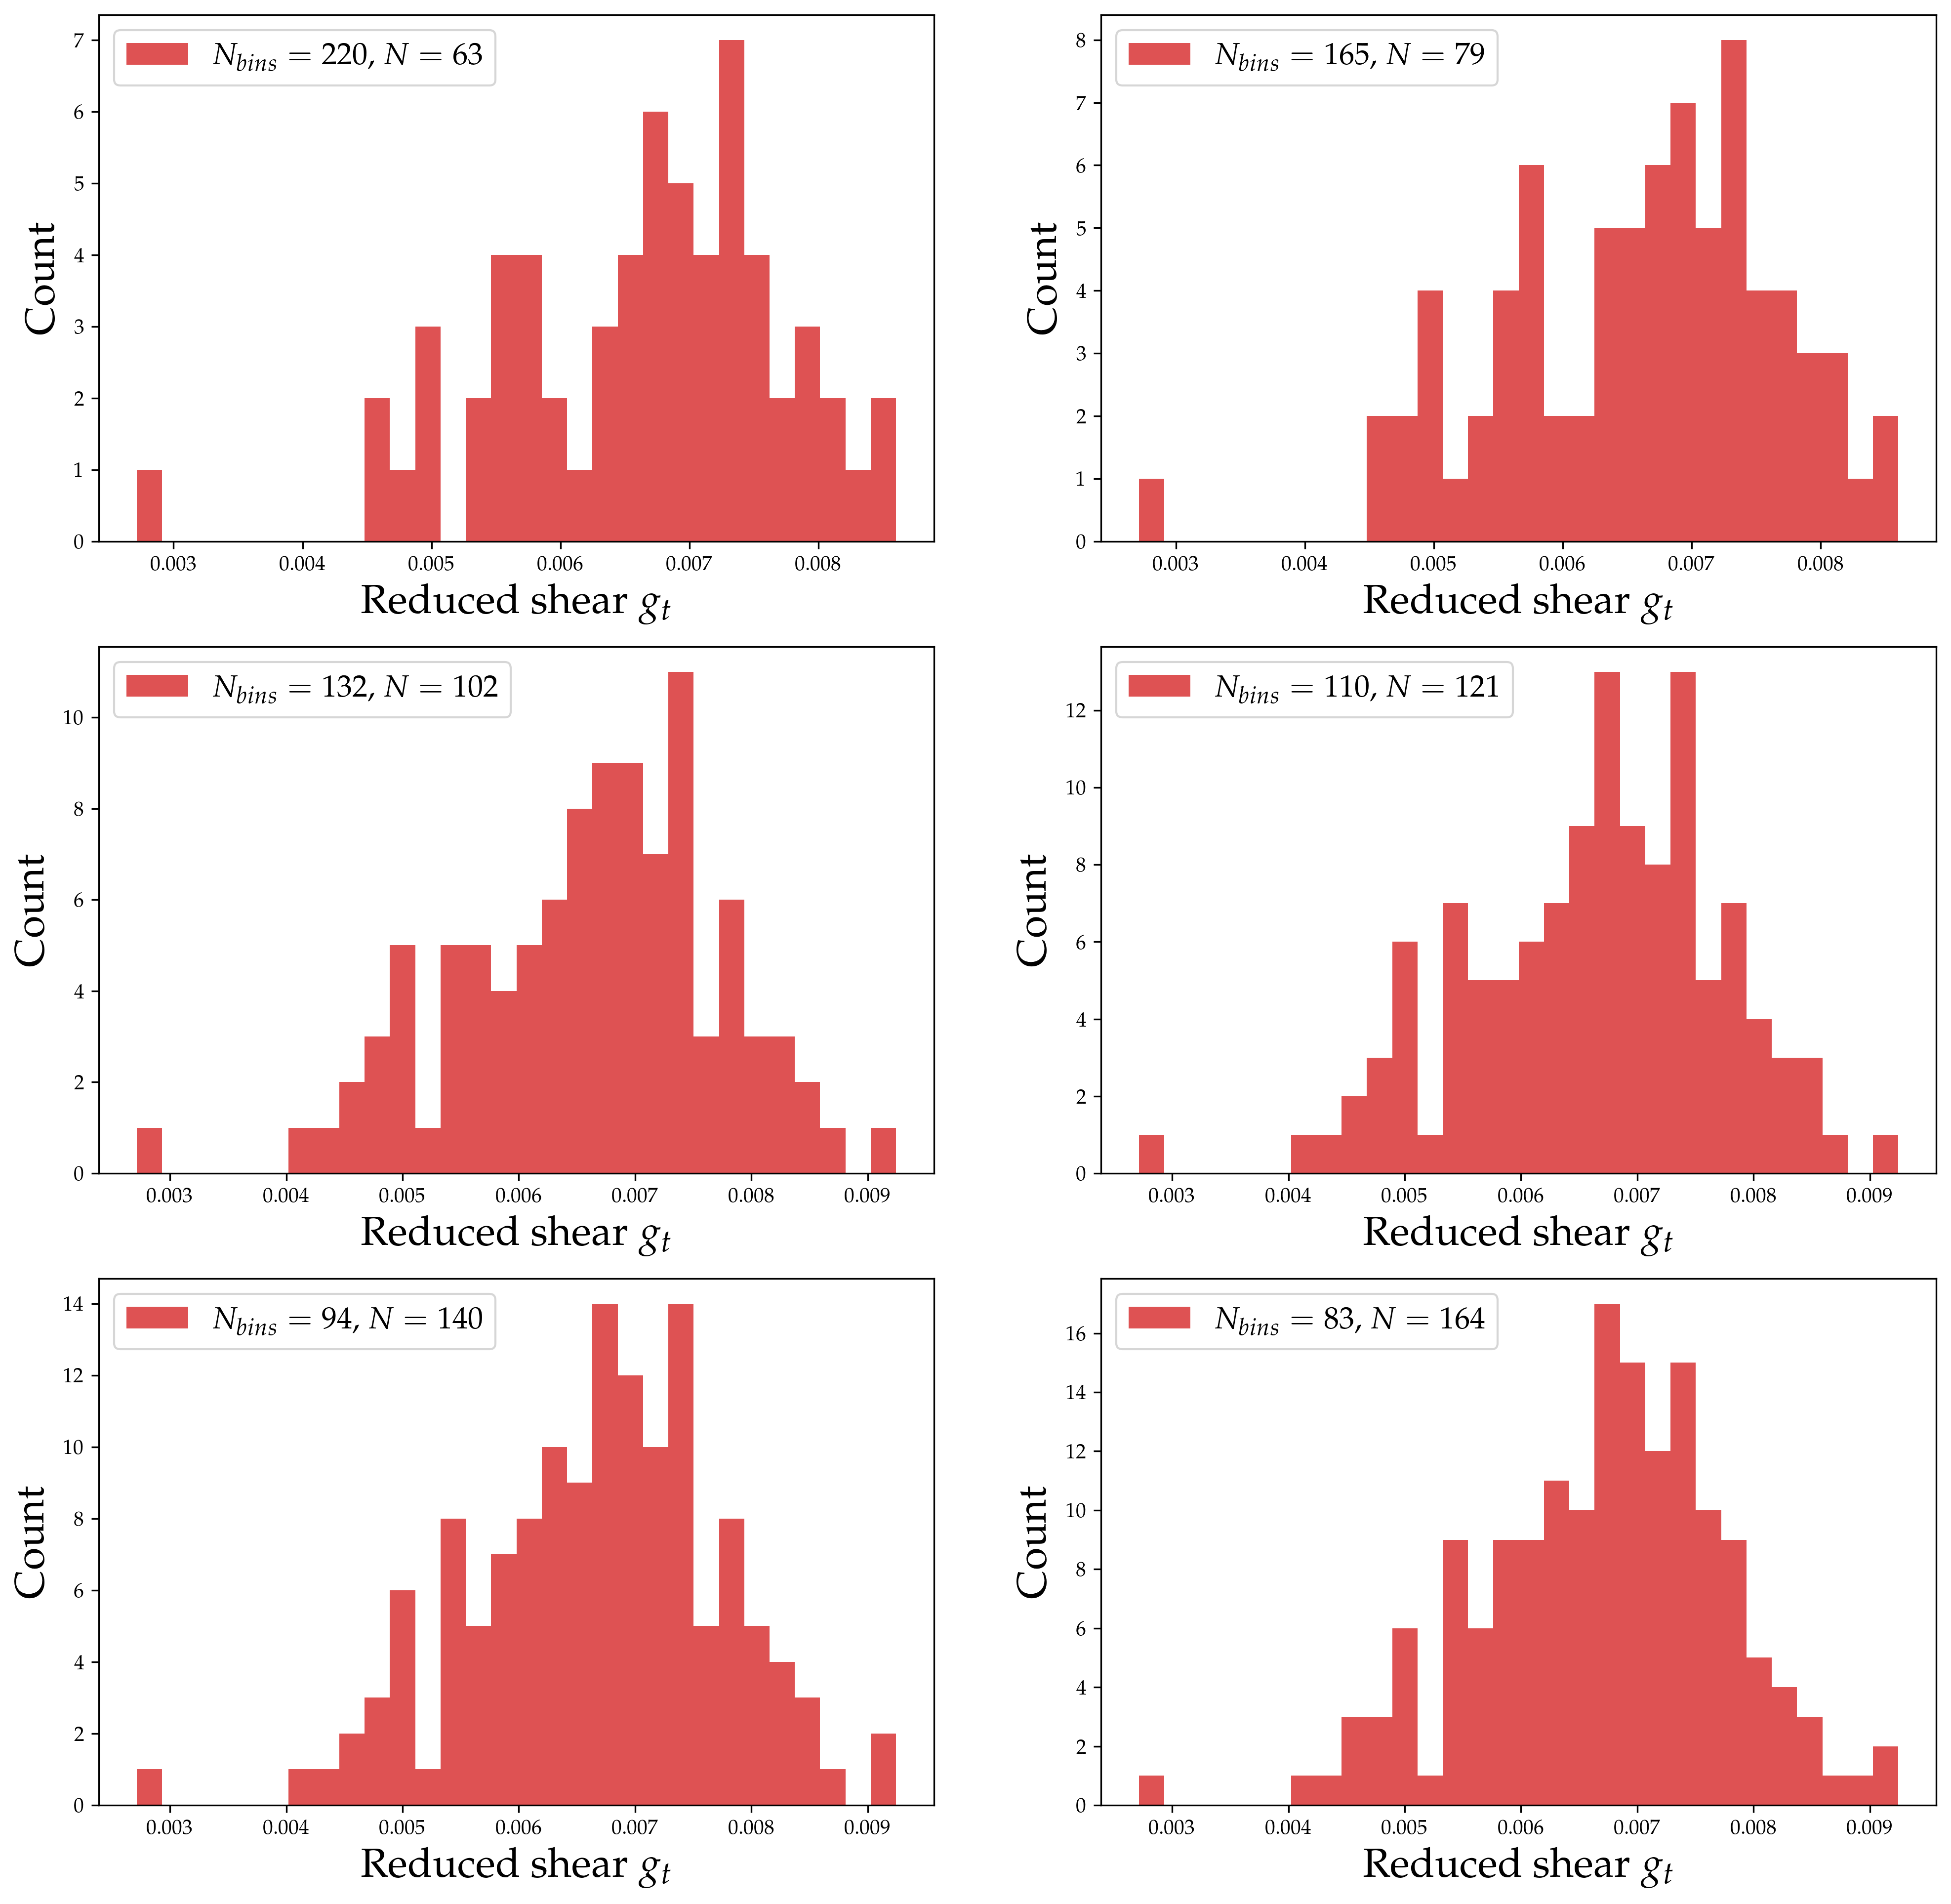

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(16,16), dpi=300, facecolor="white")

n = 220
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[0][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')

n = 165
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[0][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][1].hist(gc_gt, bins=30, alpha=0.8)
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][1].hist(gc_gt, bins=30, alpha=0.8)
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[0][1].hist(gc_gt, bins=30, alpha=0.8)


n = 132
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[1][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')


n = 110
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[1][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[1][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')


n = 94
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[2][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][0].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')


n = 83
gc = [create_mock_cluster(1e-3, r, n) for r in [0.7, (0.7, 0.05), "chang13", ("chang13", 0.05)]]
gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
ax[2][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'$N_{{bins}}={n}$, $N={len(gc_z)}$')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')
# gc_z     = [gc[1].galcat['z'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_theta = [gc[1].galcat['theta'][gal_id] for gal_id in gc[1].profile[n-1]['gal_id']]
# gc_r     = convert_units(gc_theta, 'radians', 'Mpc', redshift=gc[1].z, cosmo=cosmo)
# gc_gt    = clmm.compute_reduced_tangential_shear(gc_r, cluster_m, concentration, gc[1].z, gc_z, cosmo, delta_mdef=200, halo_profile_model='nfw')
# ax[2][1].hist(gc_gt, bins=30, alpha=0.8, color='tab:red', label=f'N_{{bins}}={n}')


ax[0][0].set_ylabel(f'Count', fontsize=20)
ax[0][1].set_ylabel(f'Count', fontsize=20)
ax[1][0].set_ylabel(f'Count', fontsize=20)
ax[1][1].set_ylabel(f'Count', fontsize=20)
ax[2][0].set_ylabel(f'Count', fontsize=20)
ax[2][1].set_ylabel(f'Count', fontsize=20)

ax[0][0].set_xlabel(f'Reduced shear $g_t$', fontsize=20)
ax[0][1].set_xlabel(f'Reduced shear $g_t$', fontsize=20)
ax[1][0].set_xlabel(f'Reduced shear $g_t$', fontsize=20)
ax[1][1].set_xlabel(f'Reduced shear $g_t$', fontsize=20)
ax[2][0].set_xlabel(f'Reduced shear $g_t$', fontsize=20)
ax[2][1].set_xlabel(f'Reduced shear $g_t$', fontsize=20)



# ax[j][0].set_xlabel(f'Tangential shear ($\\epsilon_t^{{(obs)}}$)', fontsize='20')
# ax[j][1].set_xlabel(f'Redshift ($z$)', fontsize='20')

# ax[j][0].set_ylabel(f'Number of ocurrences', fontsize='20')
# ax[j][1].set_ylabel(f'Number of ocurrences', fontsize='20')

ax[0][0].legend(fontsize=15)
ax[0][1].legend(fontsize=15)
ax[1][0].legend(fontsize=15)
ax[1][1].legend(fontsize=15)
ax[2][0].legend(fontsize=15)
ax[2][1].legend(fontsize=15)


# fig.suptitle(f'Histograms of $g_t$ for each number of bins $N_{{bins}}$ \n 0.7 + photo-$z$', fontsize='50', weight='bold')

# # fig.tight_layout()
# fig.subplots_adjust(top=0.85)